# NSMC Clustering
- 영화 리뷰에 대해 형태소 단위로 나눈 이후, 이를 이용화여 군집화 알고리즘 적용
- 영화 리뷰 중, 긍정적인 리뷰와 부정적인 리뷰를 나누어서 다음 과정을 진행
    1. 군집 개수(K) 를 임의로 설정하여 알고리즘을 실행한 이후, 리뷰들을 각 군집으로 분리
        - (이 때 이용되는 변수는 타당한 근거를 바탕으로okt_res, komoran_res, kkma_res 중 1개로 선택)
    2. 분리된 각 군집에 대해서 많이 발생한 형태소를 계산하여, 각 군집에 대한 특징을 해석하기

# 모듈 불러오기

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pprint import pprint
from collections import Counter

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans

# 데이터 불러오기

In [47]:
data = pd.read_csv("./data/2차.csv", encoding = 'utf-8')

# 데이터 확인하기

In [48]:
data.head(10)
# id : 네이버 영화 리뷰의 식별번호
# document : 네이버 영화 리뷰 내용
# label : 긍정, 부정 레이블 (긍정 : 1, 부정 : 0)
# preprocessed_document : nsmc_preprocessing.ipynb 코드에서 처리된 내용 (글자 수 12이상 15 이하)
# document_len : preprocessed_document 글자 수
# okt_res : 트위터 형태소 처리 결과
# komoran_res : 코모란 형태소 처리 결과
# kkma_res : 꼬꼬마 형태소 처리 결과

,id,document,label,preprocessed_document,document_len,v_n_ad
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,17.0,"['어리다', '보고', '지금', '다시', '재밌다', 'ㅋㅋ']"
1,9279041,완전 감동입니다 다시봐도 감동,1,완전 감동입니다 다시봐도 감동,13.0,"['완전', '감동', '다시', '감동']"
2,9250537,바보가 아니라 병 쉰 인듯,1,바보가 아니라 병 쉰 인듯,10.0,"['바보', '병', '쉰']"
3,9537008,고질라니무 귀엽다능ㅋㅋ,1,고질라니무 귀엽다능ㅋㅋ,11.0,"['고질', '귀엽다', 'ㅋㅋ']"
4,8703997,가면 갈수록 더욱 빠져드네요 밀회 화이팅!!,1,가면 갈수록 더욱 빠져드네요 밀회 화이팅,17.0,"['가면', '갈수록', '더욱', '빠지다', '밀회', '화이팅']"
5,5185638,오랜만에 본 제대로 된 범죄스릴러~,1,오랜만에 본 제대로 된 범죄스릴러,14.0,"['만', '제대로', '되다', '범죄', '스릴러']"
6,486781,마지막씬을 잊을수가 없다,1,마지막씬을 잊을수가 없다,11.0,"['마지막', '씬', '잊다', '없다']"
7,7776793,"강압적용서,세뇌적용서에 대한 비판",1,강압적용서세뇌적용서에 대한 비판,15.0,"['강압', '용서', '세뇌', '용서', '대한', '비판']"
8,9694764,중세시대명작. 굿 평점이왜이래,1,중세시대명작 굿 평점이왜이래,13.0,"['명작', '굿', '평점', '왜']"
9,10225238,농아인문화에 대한 알아야 합니다.,1,농아인문화에 대한 알아야 합니다,14.0,"['농아인', '문화', '대한']"


In [49]:
data.shape # 데이터 행과 열 개수 확인

(53165, 6)

# 영화 리뷰에 대해 형태소 길이를 계산하고 시각화를 통해 데이터를 탐색

In [50]:
okt_token_len = data["v_n_ad"].apply(lambda x: len(x.split(','))) # ,(comma) 기준으로 나누었을 때 형태소 단위로 분리되며 이에 대한 개수, 즉 형태소 개수를 계산하는 함수

In [51]:
tmp_df = pd.DataFrame({"v_n_ad" : data["v_n_ad"], "v_n_ad_token_len" : okt_token_len}) # 형태소 단위에 대해서 형태소 개수를 데이터 프레임으로 변환

Text(0.5, 1.0, 'The Distribution of Length over the Movie Reviews (v_n_ad Token)')

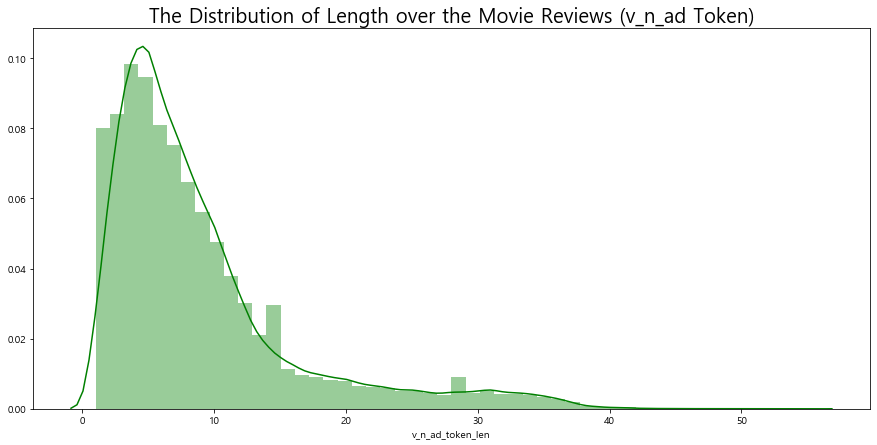

In [53]:
plt.rcParams["figure.figsize"] = (15, 7) # 그래프 크기 지정
sns.distplot(tmp_df["v_n_ad_token_len"], color = "green") # 단일 변량 분포 그래프
plt.title("The Distribution of Length over the Movie Reviews (v_n_ad Token)", fontsize = 20) # 그래프 제목, 글자 크기는 20 지정

# 긍정적인 리뷰에 대해 어떠한 형태소가 많이 발생하였는지 계산하기
- CountVectorizer (예시)
    - 문장 (1) : 나는 너를 좋아한다.
    - 문장 (1) 형태소 분석기 결과 : '나', '너', '좋아함'
    
    - 문장 (2) : 너는 사과를 좋아한다.
    - 문장 (2) 형태소 분석기 결과 : '너', '사과', '좋아함'
    
    - 문장 (3) : 나는 사과를 좋아한다.
    - 문장 (3) 형태소 분석기 결과 : '나', '사과', '좋아함'

- CountVectorizer (결과) : ['나' '너' '좋아함' '사과']
    - 문장 (1) : [1, 1, 0, 1]
    - 문장 (2) : [0, 1, 1, 1]
    - 문장 (3) : [1, 0, 1, 1]

In [ ]:
pos_data = data[data["label"] == 1] # 긍정적인 리뷰 데이터만 추출

In [55]:
print(pos_data.shape)  # 데이터 행과 열 개수 확인

(26856, 6)


In [ ]:
pos_cv = CountVectorizer() # 형태소를 세는 객체 호출
pos_corpus = pos_data["v_n_ad"] # 꼬꼬마 형태소 처리 결과 추출
pos_cv_res = pos_cv.fit_transform(pos_corpus) # 꼬꼬마 형태소 처리 결과에 대해서 형태소 개수 계산
pos_cv_res_array = pos_cv_res.toarray() # 계산된 결과를 배열 형태로 변환

In [57]:
pos_cv_res_array.shape  # 데이터 행과 열 개수 확인

(26856, 17875)

In [59]:
print(len(pos_cv.get_feature_names())) # 전체 형태소 개수 확인

17875


In [60]:
pos_token_sum = pos_cv_res_array.sum(axis = 0) # 형태소 별 로 발생된 전체 횟수 계산
pos_word_dic = {key: value for key, value in zip(pos_cv.get_feature_names(), pos_token_sum)} # 형태소와 형태소 별 발생 횟수를 딕셔너리 자료형으로 표현
sorted(pos_word_dic.items(), key = lambda x: x[1], reverse = True) # 발생 횟수 기준으로 내림차순으로 정렬하여 확인

[('영화', 9653),
 ('좋다', 3168),
 ('재밌다', 2848),
 ('있다', 2837),
 ('너무', 2315),
 ('정말', 2262),
 ('최고', 1961),
 ('되다', 1840),
 ('없다', 1650),
 ('같다', 1568),
 ('진짜', 1468),
 ('않다', 1415),
 ('감동', 1379),
 ('연기', 1342),
 ('재미있다', 1299),
 ('생각', 1216),
 ('드라마', 1040),
 ('보고', 1016),
 ('평점', 1016),
 ('나오다', 946),
 ('사람', 898),
 ('ㅋㅋ', 880),
 ('자다', 864),
 ('다시', 860),
 ('만들다', 848),
 ('사랑', 828),
 ('배우', 798),
 ('스토리', 737),
 ('이렇다', 710),
 ('작품', 691),
 ('마지막', 674),
 ('ㅠㅠ', 653),
 ('명작', 644),
 ('싶다', 601),
 ('가다', 599),
 ('지금', 573),
 ('많다', 545),
 ('재미', 538),
 ('아름답다', 537),
 ('주다', 533),
 ('역시', 522),
 ('모르다', 512),
 ('감독', 507),
 ('넘다', 502),
 ('완전', 480),
 ('느끼다', 476),
 ('남다', 475),
 ('장면', 475),
 ('오다', 473),
 ('그렇다', 468),
 ('마음', 467),
 ('ㅎㅎ', 464),
 ('이야기', 453),
 ('내용', 452),
 ('괜찮다', 447),
 ('가슴', 446),
 ('어리다', 443),
 ('ㅋㅋㅋ', 442),
 ('하나', 442),
 ('좋아하다', 437),
 ('해주다', 437),
 ('액션', 432),
 ('차다', 431),
 ('기억', 424),
 ('정도', 424),
 ('슬프다', 423),
 ('처음', 420),
 ('시간', 412),
 ('인생',

# 부정적인 리뷰에 대해 어떠한 형태소가 많이 발생하였는지 계산하기

In [ ]:
neg_data = data[data["label"] == 0] # 부정적인 리뷰 데이터만 추출

In [62]:
print(neg_data.shape) # 데이터 행과 열 개수 확인

(26309, 6)


In [ ]:
neg_cv = CountVectorizer() # 형태소를 세는 객체 호출
neg_corpus = neg_data["v_n_ad"] # 꼬꼬마 형태소 처리 결과 추출
neg_cv_res = neg_cv.fit_transform(neg_corpus) # 꼬꼬마 형태소 처리 결과에 대해서 형태소 개수 계산
neg_cv_res_array = neg_cv_res.toarray() # 계산된 결과를 배열 형태로 변환

In [64]:
neg_cv_res_array.shape # 데이터 행과 열 개수 확인

(26309, 18515)

In [65]:
neg_cv.get_feature_names() # neg_cv_res_array의 각 열 별 형태소 이름 확인

['ㄱㄱ',
 'ㄱㄱㄱ',
 'ㄱㄱㄱㄱ',
 'ㄱㅇㅅ',
 'ㄱㅈㄴ',
 'ㄱㅊ',
 'ㄱㅋ',
 'ㄱㅋㅋ',
 'ㄲㄲ',
 'ㄲㅈ',
 'ㄲㅊ',
 'ㄲㅋㅋㅋ',
 'ㄴㄱㅅㄱ',
 'ㄴㄴ',
 'ㄴㄷㅎ',
 'ㄴㄹ',
 'ㄴㅈ',
 'ㄷㄱ',
 'ㄷㄱㄷㄱㄷㄱㄷㄱ',
 'ㄷㄷ',
 'ㄷㄷㄷ',
 'ㄷㄷㄷㄷ',
 'ㄷㄷㄷㄷㄷㄷ',
 'ㄷㅇ',
 'ㄷㅏ',
 'ㄷㅔ',
 'ㄹㄱ',
 'ㄹㄴ',
 'ㄹㄹ',
 'ㄹㅁ',
 'ㄹㅇ',
 'ㄹㅇㅇㅈ',
 'ㄹㅋ',
 'ㄹㅏ',
 'ㅁㄴㅇ',
 'ㅁㄹ',
 'ㅁㅁ',
 'ㅁㅃㅃ',
 'ㅁㅈㅎ',
 'ㅁㅊ',
 'ㅁㅊㅋㅋㅋㅋㅋㅋㅋㅋㅋ',
 'ㅁㅋㅋㅋㅋ',
 'ㅁㅎ',
 'ㅂㄷㅂㄷ',
 'ㅂㅂㅂㄱ',
 'ㅂㅂㅂㅂㅂㅂㅂㅂㅂㅂㅂㅂㅂㅂㅂㅂㅂㅂㅂㅂㅂㅂ',
 'ㅂㅃ',
 'ㅂㅅ',
 'ㅂㅇ',
 'ㅄㄷㅇ',
 'ㅅㄱ',
 'ㅅㄲ',
 'ㅅㅂ',
 'ㅅㅂㄹ',
 'ㅅㅂㅋㅋㅋㅋ',
 'ㅅㅂㅡㅡ',
 'ㅅㅅ',
 'ㅅㅅㅏㄴ',
 'ㅅㅋ',
 'ㅅㅓ',
 'ㅅㅞㅅ',
 'ㅆㄷㄱ',
 'ㅆㄹㄱ',
 'ㅆㅎㅌㅊ',
 'ㅇㄴ',
 'ㅇㄷㅈㅅ',
 'ㅇㅅㅇ',
 'ㅇㅇ',
 'ㅇㅇㅇ',
 'ㅇㅇㅇㅇ',
 'ㅇㅇㅇㅇㅇ',
 'ㅇㅇㅇㅇㅇㅇㅇㅇㅇㅇㅇㅇㅇㅇㅇㅇㅇㅇㅇㅇㅇㅇㅇㅇㅇㅇㅇㅇㅇㅇㅇㅇㅇㅇㅇㅇㅇㅇㅇㅇㅇㅇㅇㅇㅇㅇㅇㅇㅇㅇㅇㅇㅇ',
 'ㅇㅋ',
 'ㅇㅎㄹㄺ',
 'ㅇㅒ',
 'ㅇㅓ',
 'ㅇㅣ',
 'ㅈㄴ',
 'ㅈㄹ',
 'ㅈㅂㅅ',
 'ㅈㅅ',
 'ㅈㅈ',
 'ㅈㅈㅈ',
 'ㅈㅓ',
 'ㅉㅉ',
 'ㅉㅉㅉ',
 'ㅉㅉㅉㅉ',
 'ㅉㅉㅉㅉㅉ',
 'ㅉㅉㅉㅉㅉㅉ',
 'ㅉㅉㅉㅉㅉㅉㅉㅉㅉ',
 'ㅉㅉㅉㅉㅉㅉㅉㅉㅉㅉㅉㅉㅉㅉㅉㅉㅉㅉ',
 'ㅉㅏㅡㅡ',
 'ㅋㄱ',
 'ㅋㄱㄱ',
 'ㅋㄱㅋ',
 'ㅋㄲ',
 'ㅋㄷ',
 'ㅋㄷㄱ',
 'ㅋㅁㄻㄹ',
 'ㅋㅇ',
 'ㅋㅋ',
 'ㅋㅋㄱㅋㄱㄱㅋㄱㄱㄱㄱ',
 'ㅋㅋㄲ',
 'ㅋㅋㅋ',
 'ㅋㅋㅋㅅㅂㅡㅡ',
 'ㅋㅋㅋㅋ',
 'ㅋㅋㅋㅋㄱㅋ',
 'ㅋㅋㅋㅋㅋ',
 'ㅋㅋㅋㅋㅋㅋ',
 'ㅋㅋㅋㅋㅋㅋㅋ',
 'ㅋㅋㅋㅋㅋㅋㅋㅋ',

In [66]:
print(len(neg_cv.get_feature_names())) # 전체 형태소 개수 확인

18515


In [67]:
neg_token_sum = neg_cv_res_array.sum(axis = 0) # 형태소 별 로 발생된 전체 횟수 계산
neg_word_dic = {key: value for key, value in zip(neg_cv.get_feature_names(), neg_token_sum)} # 형태소와 형태소 별 발생 횟수를 딕셔너리 자료형으로 표현
sorted(neg_word_dic.items(), key = lambda x: x[1], reverse = True) # 발생 횟수 기준으로 내림차순으로 정렬하여 확인

[('영화', 8917),
 ('없다', 4044),
 ('있다', 1792),
 ('너무', 1685),
 ('진짜', 1585),
 ('만들다', 1532),
 ('같다', 1516),
 ('아깝다', 1485),
 ('않다', 1434),
 ('되다', 1420),
 ('나오다', 1414),
 ('평점', 1319),
 ('쓰레기', 1158),
 ('스토리', 1151),
 ('정말', 1150),
 ('좋다', 1132),
 ('재미없다', 1085),
 ('감독', 1039),
 ('시간', 1037),
 ('연기', 987),
 ('지루하다', 982),
 ('내용', 969),
 ('그냥', 966),
 ('이렇다', 958),
 ('사람', 905),
 ('재미', 872),
 ('최악', 827),
 ('주다', 813),
 ('배우', 776),
 ('이건', 730),
 ('보고', 719),
 ('드라마', 711),
 ('생각', 702),
 ('ㅡㅡ', 669),
 ('ㅋㅋ', 656),
 ('모르다', 646),
 ('그렇다', 637),
 ('가다', 622),
 ('안되다', 615),
 ('하나', 593),
 ('별로', 581),
 ('싶다', 552),
 ('주인공', 525),
 ('정도', 520),
 ('처음', 507),
 ('이렇게', 494),
 ('자다', 465),
 ('재밌다', 464),
 ('ㅋㅋㅋ', 457),
 ('연출', 452),
 ('오다', 441),
 ('수준', 435),
 ('버리다', 432),
 ('액션', 431),
 ('차다', 429),
 ('완전', 410),
 ('이해', 408),
 ('나다', 406),
 ('뻔하다', 401),
 ('느낌', 396),
 ('유치하다', 393),
 ('여자', 387),
 ('감동', 386),
 ('장면', 378),
 ('많다', 375),
 ('작품', 375),
 ('때문', 373),
 ('말다', 372),
 ('이야기'

# 긍정 리뷰와, 부정 리뷰들에서 가장 많이 발생한 형태소 간 비교

In [68]:
print("Positive Review's result")
pprint(sorted(pos_word_dic.items(), key = lambda x: x[1], reverse = True)[:20])
print()
print("Negative Review's result")
pprint(sorted(neg_word_dic.items(), key = lambda x: x[1], reverse = True)[:20])

Positive Review's result
[('영화', 9653),
 ('좋다', 3168),
 ('재밌다', 2848),
 ('있다', 2837),
 ('너무', 2315),
 ('정말', 2262),
 ('최고', 1961),
 ('되다', 1840),
 ('없다', 1650),
 ('같다', 1568),
 ('진짜', 1468),
 ('않다', 1415),
 ('감동', 1379),
 ('연기', 1342),
 ('재미있다', 1299),
 ('생각', 1216),
 ('드라마', 1040),
 ('보고', 1016),
 ('평점', 1016),
 ('나오다', 946)]

Negative Review's result
[('영화', 8917),
 ('없다', 4044),
 ('있다', 1792),
 ('너무', 1685),
 ('진짜', 1585),
 ('만들다', 1532),
 ('같다', 1516),
 ('아깝다', 1485),
 ('않다', 1434),
 ('되다', 1420),
 ('나오다', 1414),
 ('평점', 1319),
 ('쓰레기', 1158),
 ('스토리', 1151),
 ('정말', 1150),
 ('좋다', 1132),
 ('재미없다', 1085),
 ('감독', 1039),
 ('시간', 1037),
 ('연기', 987)]


# 빈도 시각화

In [69]:
from matplotlib import rc
from matplotlib import font_manager
plt.rcParams['axes.unicode_minus'] = False
# plt.figure(figsize=(10, 5))

# font_path = 'C:\\Windows\\Fonts\\NanumBarunGothicUltraLight.ttf' #한글 폰트 경로 
font_path = 'C:\\Windows\\Fonts\\malgun.ttf' #한글 폰트 경로 

font_name = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font_name)

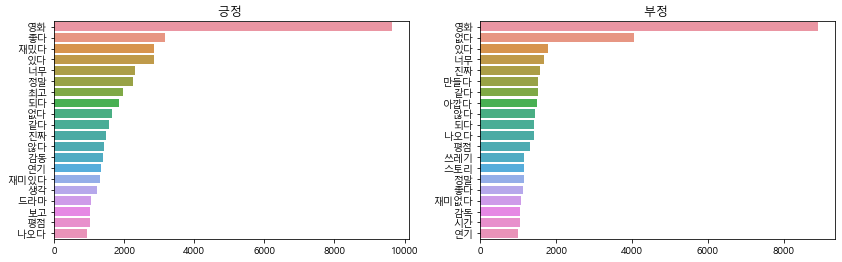

In [70]:
_pos = sorted(pos_word_dic.items(), key = lambda x: x[1], reverse = True)[:20]
_neg = sorted(neg_word_dic.items(), key = lambda x: x[1], reverse = True)[:20]
fig = plt.figure(figsize=(14, 4))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
sns.barplot([_[1] for _ in _pos], [ _[0] for _ in _pos], ax=ax1)
sns.barplot([_[1] for _ in _neg], [ _[0] for _ in _neg], ax=ax2)

ax1.title.set_text('긍정 ')
ax2.title.set_text('부정 ')

plt.show()

# 군집화
- 알고리즘 종류 : KMeans, DBSCAN
- KMeans : 데이터 간 거리가 가까운 데이터끼리 군집을 형성하는 비지도학습 알고리즘 (군집 개수 k 설정 필요)
- DBSCAN : 데이터마다 epsilon 거리 이내의 데이터들을 한 구집으로 형성하는 비지도학습 알고리즘 (군집 개수 설정 불필요)
- 참고 링크 : https://neocarus.tistory.com/entry/K-means%EC%99%80-DBSCAN-%EB%B9%84%EA%B5%90

# KMeans - 긍정 영화 리뷰

In [72]:
kmeans_clustering = KMeans(n_clusters = 3, random_state = 1114, n_init=10,
               max_iter=10).fit(pos_cv_res_array) # KMeans 알고리즘 (군집 수는 3개로 설정)

In [73]:
kmeans_clustering.labels_ # 군집화 결과 확인

array([1, 1, 1, ..., 1, 1, 2])

In [74]:
Counter(kmeans_clustering.labels_) # 각 군집으로 할당된 데이터 개수 확인

Counter({1: 17272, 2: 7023, 0: 2561})

In [75]:
pos_data["KMeans_res"] = kmeans_clustering.labels_ # 각 군집으로 할당 된 내용을 기존 데이터프레임에 추가

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [76]:
class_0 = pos_data[pos_data["KMeans_res"] == 0] # 클래스 0번 데이터만 추출
class_0_cv = CountVectorizer()
class_0_cv_res = class_0_cv.fit_transform(class_0["v_n_ad"])
class_0_cv_res_array = class_0_cv_res.toarray()
class_0_token_sum = class_0_cv_res_array.sum(axis = 0)
class_0_token_dic = {key: value for key, value in zip(class_0_cv.get_feature_names(), class_0_token_sum)}
pprint(sorted(class_0_token_dic.items(), key = lambda x: x[1], reverse = True)[:20])

[('좋다', 2938),
 ('영화', 823),
 ('너무', 559),
 ('있다', 344),
 ('정말', 321),
 ('연기', 304),
 ('재밌다', 245),
 ('같다', 236),
 ('나오다', 177),
 ('진짜', 168),
 ('배우', 160),
 ('되다', 157),
 ('드라마', 155),
 ('생각', 154),
 ('않다', 152),
 ('스토리', 132),
 ('없다', 130),
 ('감동', 128),
 ('재미있다', 120),
 ('내용', 117)]


In [77]:
class_1 = pos_data[pos_data["KMeans_res"] == 1] # 클래스 1번 데이터만 추출
class_1_cv = CountVectorizer()
class_1_cv_res = class_1_cv.fit_transform(class_1["v_n_ad"])
class_1_cv_res_array = class_1_cv_res.toarray()
class_1_token_sum = class_1_cv_res_array.sum(axis = 0)
class_1_token_dic = {key: value for key, value in zip(class_1_cv.get_feature_names(), class_1_token_sum)}
pprint(sorted(class_1_token_dic.items(), key = lambda x: x[1], reverse = True)[:20])

[('재밌다', 2012),
 ('있다', 1439),
 ('너무', 1227),
 ('최고', 1183),
 ('정말', 1133),
 ('없다', 959),
 ('진짜', 951),
 ('되다', 923),
 ('재미있다', 911),
 ('드라마', 854),
 ('같다', 770),
 ('감동', 757),
 ('연기', 741),
 ('않다', 721),
 ('ㅋㅋ', 621),
 ('평점', 601),
 ('보고', 505),
 ('사랑', 505),
 ('생각', 496),
 ('ㅠㅠ', 466)]


In [78]:
class_2 = pos_data[pos_data["KMeans_res"] == 2] # 클래스 2번 데이터만 추출
class_2_cv = CountVectorizer()
class_2_cv_res = class_2_cv.fit_transform(class_2["v_n_ad"])
class_2_cv_res_array = class_2_cv_res.toarray()
class_2_token_sum = class_2_cv_res_array.sum(axis = 0)
class_2_token_dic = {key: value for key, value in zip(class_2_cv.get_feature_names(), class_2_token_sum)}
pprint(sorted(class_2_token_dic.items(), key = lambda x: x[1], reverse = True)[:20])

[('영화', 8830),
 ('있다', 1054),
 ('정말', 808),
 ('되다', 760),
 ('최고', 684),
 ('재밌다', 591),
 ('생각', 566),
 ('같다', 562),
 ('없다', 561),
 ('않다', 542),
 ('너무', 529),
 ('감동', 494),
 ('만들다', 440),
 ('보고', 403),
 ('자다', 352),
 ('진짜', 349),
 ('사람', 333),
 ('다시', 332),
 ('평점', 331),
 ('나오다', 322)]


In [85]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

In [80]:
word = sorted(class_0_token_dic.items(), key=lambda t : t[1], reverse=True)[:50]

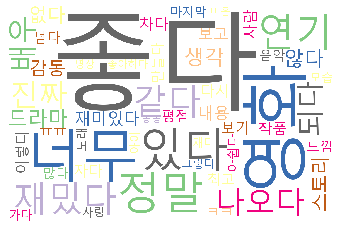

In [86]:
wordcloud = WordCloud(font_path = 'C:/Windows/Fonts/malgun.ttf', 
                      background_color='white',colormap = "Accent_r", 
                      width=1500, height=1000).generate_from_frequencies(dict(word)) 
plt.imshow(wordcloud) 
plt.axis('off') 
plt.show()


In [87]:
word = sorted(class_1_token_dic.items(), key=lambda t : t[1], reverse=True)[:50]

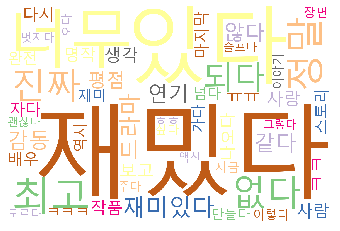

In [88]:
wordcloud = WordCloud(font_path = 'C:/Windows/Fonts/malgun.ttf', 
                      background_color='white',colormap = "Accent_r", 
                      width=1500, height=1000).generate_from_frequencies(dict(word)) 
plt.imshow(wordcloud) 
plt.axis('off') 
plt.show()

In [89]:
word = sorted(class_2_token_dic.items(), key=lambda t : t[1], reverse=True)[:50]

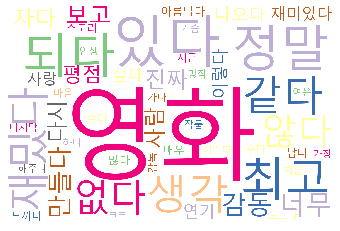

In [90]:
wordcloud = WordCloud(font_path = 'C:/Windows/Fonts/malgun.ttf', 
                      background_color='white',colormap = "Accent_r", 
                      width=1500, height=1000).generate_from_frequencies(dict(word)) 
plt.imshow(wordcloud) 
plt.axis('off') 
plt.show()

# KMeans - 부정 영화 리뷰

In [91]:
kmeans_clustering = KMeans(n_clusters = 3, random_state = 1114,n_init=10,
               max_iter=10).fit(neg_cv_res_array) # KMeans 알고리즘 (군집 수는 3개로 설정)

In [92]:
kmeans_clustering.labels_ # 군집화 결과 확인

array([2, 2, 1, ..., 0, 2, 2])

In [93]:
Counter(kmeans_clustering.labels_) # 각 군집으로 할당된 데이터 개수 확인

Counter({2: 18038, 1: 6975, 0: 1296})

In [94]:
neg_data["KMeans_res"] = kmeans_clustering.labels_ # 각 군집으로 할당 된 내용을 기존 데이터프레임에 추가

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [96]:
class_0 = neg_data[neg_data["KMeans_res"] == 0] # 클래스 0번 데이터만 추출
class_0_cv = CountVectorizer()
class_0_cv_res = class_0_cv.fit_transform(class_0["v_n_ad"])
class_0_cv_res_array = class_0_cv_res.toarray()
class_0_token_sum = class_0_cv_res_array.sum(axis = 0)
class_0_token_dic = {key: value for key, value in zip(class_0_cv.get_feature_names(), class_0_token_sum)}
pprint(sorted(class_0_token_dic.items(), key = lambda x: x[1], reverse = True)[:20])

[('진짜', 1453),
 ('영화', 374),
 ('없다', 244),
 ('재미없다', 168),
 ('아깝다', 155),
 ('나오다', 135),
 ('쓰레기', 122),
 ('연기', 112),
 ('ㅡㅡ', 110),
 ('평점', 105),
 ('같다', 104),
 ('있다', 103),
 ('이건', 95),
 ('만들다', 94),
 ('너무', 93),
 ('시간', 86),
 ('스토리', 85),
 ('오다', 78),
 ('사람', 74),
 ('ㅋㅋ', 73)]


In [97]:
class_1 = neg_data[neg_data["KMeans_res"] == 1] # 클래스 1번 데이터만 추출
class_1_cv = CountVectorizer()
class_1_cv_res = class_1_cv.fit_transform(class_1["v_n_ad"])
class_1_cv_res_array = class_1_cv_res.toarray()
class_1_token_sum = class_1_cv_res_array.sum(axis = 0)
class_1_token_dic = {key: value for key, value in zip(class_1_cv.get_feature_names(), class_1_token_sum)}
pprint(sorted(class_1_token_dic.items(), key = lambda x: x[1], reverse = True)[:20])

[('영화', 8543),
 ('없다', 1325),
 ('만들다', 766),
 ('있다', 661),
 ('같다', 596),
 ('쓰레기', 570),
 ('아깝다', 559),
 ('되다', 490),
 ('이렇다', 488),
 ('나오다', 469),
 ('않다', 454),
 ('정말', 450),
 ('너무', 441),
 ('최악', 438),
 ('평점', 424),
 ('감독', 418),
 ('시간', 376),
 ('그냥', 359),
 ('좋다', 339),
 ('사람', 311)]


In [98]:
class_2 = neg_data[neg_data["KMeans_res"] == 2] # 클래스 2번 데이터만 추출
class_2_cv = CountVectorizer()
class_2_cv_res = class_2_cv.fit_transform(class_2["v_n_ad"])
class_2_cv_res_array = class_2_cv_res.toarray()
class_2_token_sum = class_2_cv_res_array.sum(axis = 0)
class_2_token_dic = {key: value for key, value in zip(class_2_cv.get_feature_names(), class_2_token_sum)}
pprint(sorted(class_2_token_dic.items(), key = lambda x: x[1], reverse = True)[:20])

[('없다', 2475),
 ('너무', 1151),
 ('있다', 1028),
 ('않다', 917),
 ('되다', 878),
 ('같다', 816),
 ('나오다', 810),
 ('평점', 790),
 ('아깝다', 771),
 ('스토리', 762),
 ('좋다', 737),
 ('재미없다', 673),
 ('만들다', 672),
 ('지루하다', 668),
 ('정말', 648),
 ('연기', 625),
 ('내용', 600),
 ('재미', 583),
 ('드라마', 576),
 ('시간', 575)]


# 문제
- 긍정적인 영화 리뷰와 부정적인 영화 리뷰를 적절하게 군집화하고, 각 군집별 특징을 해석하세요.
- 제출 파일 : 분석 과정 PPT, 소스 코드

## Tip
- 영화 리뷰 길이 조정
- 형태소 분석기 활용 (참고 : https://konlpy-ko.readthedocs.io/ko/v0.4.3/)
- CountVectorizer 활용 (예; 일정 개수 이하는 제거, '영화' 형태소는 제거 등)

# 워드클라우드

In [99]:
word = sorted(class_0_token_dic.items(), key=lambda t : t[1], reverse=True)[:50]

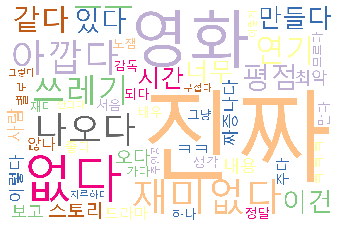

In [100]:
wordcloud = WordCloud(font_path = 'C:/Windows/Fonts/malgun.ttf', 
                      background_color='white',colormap = "Accent_r", 
                      width=1500, height=1000).generate_from_frequencies(dict(word)) 
plt.imshow(wordcloud) 
plt.axis('off') 
plt.show()


In [101]:
word = sorted(class_1_token_dic.items(), key=lambda t : t[1], reverse=True)[:50]

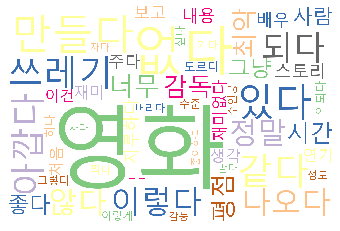

In [102]:
wordcloud = WordCloud(font_path = 'C:/Windows/Fonts/malgun.ttf', 
                      background_color='white',colormap = "Accent_r", 
                      width=1500, height=1000).generate_from_frequencies(dict(word)) 
plt.imshow(wordcloud) 
plt.axis('off') 
plt.show()


In [103]:
word = sorted(class_2_token_dic.items(), key=lambda t : t[1], reverse=True)[:50]

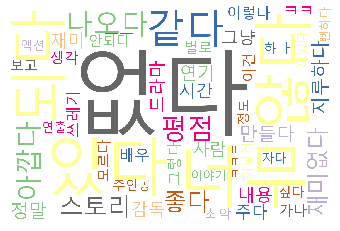

In [104]:
wordcloud = WordCloud(font_path = 'C:/Windows/Fonts/malgun.ttf', 
                      background_color='white',colormap = "Accent_r", 
                      width=1500, height=1000).generate_from_frequencies(dict(word)) 
plt.imshow(wordcloud) 
plt.axis('off') 
plt.show()
